In [2]:
ls /datasets/conflearn/seg/battery/images

2022-03-16-142148.jpg  2022-03-16-163228.jpg  2022-03-16-164624.jpg
2022-03-16-142150.jpg  2022-03-16-163230.jpg  2022-03-16-164626.jpg
2022-03-16-142152.jpg  2022-03-16-163231.jpg  2022-03-16-164627.jpg
2022-03-16-142154.jpg  2022-03-16-163233.jpg  2022-03-16-164629.jpg
2022-03-16-142156.jpg  2022-03-16-163234.jpg  2022-03-16-164631.jpg
2022-03-16-142158.jpg  2022-03-16-163236.jpg  2022-03-16-164633.jpg
2022-03-16-142200.jpg  2022-03-16-163237.jpg  2022-03-16-164634.jpg
2022-03-16-142201.jpg  2022-03-16-163239.jpg  2022-03-16-164636.jpg
2022-03-16-142203.jpg  2022-03-16-163241.jpg  2022-03-16-164638.jpg
2022-03-16-142205.jpg  2022-03-16-163242.jpg  2022-03-16-164640.jpg
2022-03-16-142207.jpg  2022-03-16-163244.jpg  2022-03-16-164641.jpg
2022-03-16-142208.jpg  2022-03-16-163245.jpg  2022-03-16-164643.jpg
2022-03-16-142210.jpg  2022-03-16-163247.jpg  2022-03-16-164645.jpg
2022-03-16-142212.jpg  2022-03-16-163249.jpg  2022-03-16-164646.jpg
2022-03-16-142213.jpg  2022-03-16-163251.jpg  20

In [3]:
from imagesize import imagesize
imagesize.get("/datasets/conflearn/seg/battery/images/2022-03-16-163226.jpg")

(640, 398)

In [4]:
from PIL import Image 
Image.open("/datasets/conflearn/seg/battery/images/2022-03-16-163226.jpg").size

(640, 398)

# Classification

In [ ]:
from typing import Literal

import numpy as np

class Classification:
    def __init__(self, labels, preds, num_classes):
        self.labels = labels
        self.preds = preds
        self.num_classes = num_classes

    def per_class_thresholds(self):
        thresholds = np.zeros(self.num_classes)
        for i in range(self.num_classes):
            # Self-confidence of predictions whose GT label is i 
            p_i = self.preds[self.labels == i, i]
            # Threshold is the mean of self-confidence
            thresholds[i] = np.mean(p_i)

        assert thresholds.nonzero()[0].shape[0] == self.num_classes, "Some classes have no predictions"
        return thresholds

    def get_result(self, method: Literal["pl", "cl"] = "cl", score_method: Literal["self_confidence", "normalized_margin"] = "self_confidence"):
        """
        Args:
            method: 
                1. pl: pseudo-labeling
                    Errors: pseudo-labels do not match with GT labels 
                    Scores: confidence of pseudo-labels
                2. cl: confident learning 
                    Errors: off-diagonal elements of the confident joint
                    Scores: 
            score_method:
                1. self_confidence: self-confidence of predictions
                2. normalized_margin: p_y-p_{y'}, y'=argmax_k!=y p_k 
        Returns:
            error_indices: indices of error predictions
            label_quality_scores: quality scores of pseudo-labels
        """
        match method:
            case "pl":
                pseudo_labels = self.preds.argmax(axis=1)
                error_indices = (pseudo_labels != self.labels).nonzero()[0]

            case "cl":
                thresholds = self.per_class_thresholds()
                above_thresholds = self.preds >= thresholds
                pseudo_labels = self.preds.argmax(axis=1)
                
                error_indices = []
                for i in range(len(self.preds)):
                    indices = above_thresholds[i].nonzero()[0]
                    if len(indices) == 0:
                        continue
                    
                    j = indices[self.preds[i, indices].argmax()]

                    if self.preds[i, j] >= thresholds[j] and j != self.labels[i]:
                        error_indices.append(i)

                error_indices = np.array(error_indices)
                
            case "PBC":
                raise NotImplementedError
        
            case "PBNR":
                raise NotImplementedError

            case "C+NR":
                raise NotImplementedError

            case _:
                raise ValueError(f"Unknown method: {method}")
        
        match score_method:
            case "self_confidence":
                label_quality_scores = self.preds[np.arange(len(self.preds)), self.labels]
            
            case "normalized_margin":
                # p_y-p_{y'}, y'=argmax_k!=y p_k 
                self_confidence = self.preds[np.arange(len(self.preds)), self.labels]
                preds = self.preds.copy()
                preds[np.arange(len(self.preds)), self.labels] = 0
                max_confidence = preds.max(axis=1)
                label_quality_scores = 0.5 + (self_confidence - max_confidence) / 2

            case _:
                raise ValueError(f"Unknown score_method: {score_method}")
            
        return error_indices, label_quality_scores

In [ ]:
from torchvision import models
weights = models.get_weight("ResNet18_Weights.IMAGENET1K_V1")
resnet18 = models.resnet18(weights=weights)
transform = weights.transforms(antialias=True)

from torchvision.datasets import ImageNet
imagenet = ImageNet(root="/datasets/imagenet/val", split="val", transform=transform)

from torch.utils.data import DataLoader
dataloader = DataLoader(imagenet, batch_size=128, num_workers=8)


In [ ]:
from tqdm import tqdm
resnet18 = resnet18.cuda().eval()

p_ij = []
y_i = []

for images, labels in tqdm(dataloader):
    images = images.cuda()
    preds = resnet18(images).softmax(dim=1).detach().cpu().numpy()
    labels = labels.numpy()

    p_ij.append(preds)
    y_i.append(labels)    

In [ ]:
cat_p_ij = np.concatenate(p_ij, axis=0)
cat_y_i = np.concatenate(y_i, axis=0)

In [ ]:
import torch
torch.save(cat_p_ij, "cla_p.pt")
torch.save(cat_y_i, "cla_y.pt")

In [ ]:
cla=Classification(cat_y_i, cat_p_ij, num_classes=1000)

In [ ]:
indices, scores = cla.get_result("cl", "normalized_margin")

In [ ]:
from cleanlab.filter import find_label_issues
cl_indices = find_label_issues(cat_y_i, cat_p_ij, filter_by="confident_learning").nonzero()[0]

In [ ]:
from cleanlab.filter import get_label_quality_scores
cl_sc = get_label_quality_scores(cat_y_i, cat_p_ij, method="normalized_margin")

# Object detection

In [1]:
import numpy as np

from src.eval_utils import batch_iou
# Test Case 1: Basic Overlap
boxes1_basic_overlap = np.array([[1, 1, 3, 3]])
boxes2_basic_overlap = np.array([[2, 2, 4, 4]])
iou_matrix_basic_overlap = np.array([[0.14285714]])

# Test Case 2: No Overlap
boxes1_no_overlap = np.array([[1, 1, 2, 2]])
boxes2_no_overlap = np.array([[3, 3, 4, 4]])
iou_matrix_no_overlap = np.array([[0.]])

# Test Case 3: Full Overlap (One Box Inside Another)
boxes1_full_overlap = np.array([[1, 1, 5, 5]])
boxes2_full_overlap = np.array([[2, 2, 3, 3]])
iou_matrix_full_overlap = np.array([[0.0625]])

# Test Case 4: Edge Touching
boxes1_edge_touching = np.array([[1, 1, 2, 2]])
boxes2_edge_touching = np.array([[2, 2, 3, 3]])
iou_matrix_edge_touching = np.array([[0.]])

# Test Case 5: Identical Boxes
boxes1_identical = np.array([[1, 1, 3, 3]])
boxes2_identical = np.array([[1, 1, 3, 3]])
iou_matrix_identical = np.array([[1.]])

# Test Case 6: Multiple Boxes with Various Overlaps
boxes1_multiple = np.array([[1, 1, 3, 3], [4, 4, 6, 6]])
boxes2_multiple = np.array([[2, 2, 4, 4], [5, 5, 7, 7]])
iou_matrix_multiple = np.array([
    [0.14285714, 0.],
    [0., 0.14285714]
])

# Test Case 7: Negative Coordinates
boxes1_negative = np.array([[-3, -3, -1, -1]])
boxes2_negative = np.array([[-2, -2, 0, 0]])
iou_matrix_negative = np.array([[0.14285714]])

test_cases = [(boxes1_basic_overlap, boxes2_basic_overlap, iou_matrix_basic_overlap), 
              (boxes1_no_overlap, boxes2_no_overlap, iou_matrix_no_overlap), 
              (boxes1_full_overlap, boxes2_full_overlap, iou_matrix_full_overlap),
              (boxes1_edge_touching, boxes2_edge_touching, iou_matrix_edge_touching),
              (boxes1_identical, boxes2_identical, iou_matrix_identical),
              (boxes1_multiple, boxes2_multiple, iou_matrix_multiple),
              (boxes1_negative, boxes2_negative, iou_matrix_negative)]


for i, (boxes1, boxes2, expected_iou_matrix) in enumerate(test_cases):
    print(f"Test Case {i+1}: {np.allclose(batch_iou(boxes1, boxes2), expected_iou_matrix)}")

ModuleNotFoundError: No module named 'src'

In [1]:
import sys
sys.path.append("/workspace")

from tqdm import tqdm
import numpy as np

from src.conflearn.utils import batch_iou, similarity, softmin1d_pooling

class Detection:
    def __init__(self, labels, preds, num_classes):
        self.labels = labels
        self.preds = preds
        self.num_classes = num_classes
    
    def badloc_scores(self, pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, min_confidence, alpha):
        scores = []
        for gt_box, gt_label in zip(gt_boxes, gt_labels):
            overlapping = (batch_iou(gt_box, pred_boxes) > 0).squeeze(0)
            confident = pred_scores >= min_confidence
            matching = pred_labels == gt_label

            if np.any(matching & confident & overlapping):
                score = similarity(pred_boxes[matching & confident & overlapping], gt_box, alpha).max()

            else:
                score = 1.0
            
            scores.append(score)

        return scores
    
    def overlooked_scores(self, pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, min_similarity, min_confidence, alpha):
        if len(gt_boxes) == 0:
            scores = (pred_scores >= min_confidence).astype(float)
            scores[scores == 0.0] = np.nan
            return scores
        
        scores = []
        for predicted_box, predicted_confidence, predicted_label in zip(pred_boxes, pred_scores, pred_labels):
            overlapping = (batch_iou(predicted_box, gt_boxes) > 0).squeeze(0)
            confident = predicted_confidence >= min_confidence
            matching = gt_labels == predicted_label

            if not confident or np.any(overlapping):
                score = np.nan

            else:
                if not np.any(matching):
                    score = min_similarity * (1-predicted_confidence)

                else:
                    score = similarity(predicted_box, gt_boxes[matching], alpha).max()

            scores.append(score)

        return scores

    def swapped_scores(self, pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, min_confidence, alpha):
        scores = []
        for gt_box, gt_label in zip(gt_boxes, gt_labels):
            # Find predictions of different classes with high confidence
            high_confidence_wrong_class = (pred_labels != gt_label) & (pred_scores > min_confidence)
            if not np.any(high_confidence_wrong_class):
                score = 1.0  # Default score when there are no high confidence wrong class predictions

            else:
                wrong_class_boxes = pred_boxes[high_confidence_wrong_class]
                score = 1 - similarity(gt_box, wrong_class_boxes, alpha).max()
            scores.append(score)

        return scores
    
    def min_similarity(self, alpha):
        preds = self.preds
        labels = self.labels
        
        min_similarity = 1.0
        for pred, label in zip(preds, labels):
            pred_boxes = pred["boxes"]
            gt_boxes = label["boxes"]
            
            # Skip if there are no predictions or GT boxes
            if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                continue
            
            similarity_matrix = similarity(pred_boxes, gt_boxes, alpha=alpha)
            positive_similarity = similarity_matrix[similarity_matrix > 0]

            if positive_similarity.size == 0:
                continue
            
            min_similarity = min(min_similarity, positive_similarity.min())

        return min_similarity        
    
    def get_result(self, alpha=0.1, badloc_min_confidence=0.5, min_confidence = 0.95, pooling=True, softmin_temperature=0.1):
        preds = self.preds
        labels = self.labels

        min_similarity = self.min_similarity(alpha=alpha)

        badloc_scores = []
        overlooked_scores = []
        swapped_scores = []

        for pred, label in tqdm(zip(preds, labels), total=len(preds), desc="Calculating scores"):
            pred_boxes = pred["boxes"]
            pred_scores = pred["scores"]
            pred_labels = pred["labels"]

            gt_boxes = label["boxes"]
            gt_labels = label["labels"]

            badloc_scores_per_box = self.badloc_scores(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, badloc_min_confidence, alpha)
            overlooked_scores_per_box = self.overlooked_scores(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, min_similarity, min_confidence, alpha)
            swapped_scores_per_box = self.swapped_scores(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, min_confidence, alpha)

            assert len(badloc_scores_per_box) == len(gt_boxes)
            assert len(overlooked_scores_per_box) == len(pred_boxes)
            assert len(swapped_scores_per_box) == len(gt_boxes)

            if pooling:
                badloc_scores_per_box = softmin1d_pooling(badloc_scores_per_box, temperature=softmin_temperature)
                overlooked_scores_per_box = softmin1d_pooling(overlooked_scores_per_box, temperature=softmin_temperature)
                swapped_scores_per_box = softmin1d_pooling(swapped_scores_per_box, temperature=softmin_temperature)

            badloc_scores.append(badloc_scores_per_box)
            overlooked_scores.append(overlooked_scores_per_box)
            swapped_scores.append(swapped_scores_per_box)

        return badloc_scores, overlooked_scores, swapped_scores        

In [2]:
# from torchvision import models
# import torch
# weights = models.get_weight("FasterRCNN_ResNet50_FPN_Weights.COCO_V1")
# model = models.detection.fasterrcnn_resnet50_fpn(weights=weights, box_score_thresh=0.5)
# transform = weights.transforms()

# from torchvision.datasets import CocoDetection
# coco = CocoDetection(
#     root="/datasets/coco/val2017", 
#     annFile="/datasets/coco/annotations_trainval2017/annotations/instances_val2017.json", 
#     transform=transform,
#     target_transform=None
# )

# import numpy as np
# from tqdm import tqdm
# model = model.cuda().eval()

# p_ij = []
# y_i = []

# for images, labels in tqdm(coco):
#     images = images.cuda().unsqueeze(0)
#     preds = model(images)

#     temp_boxes = []
#     temp_labels = []
#     for label in labels:
#         bbox = label["bbox"]
#         # x1, y1, w, h to x1, y1, x2, y2
#         bbox[2] = bbox[0] + bbox[2]
#         bbox[3] = bbox[1] + bbox[3]
#         temp_boxes.append(bbox)
#         temp_labels.append(label["category_id"])

#     temp_boxes = np.array(temp_boxes)
#     temp_labels = np.array(temp_labels)

#     for k, v in preds[0].items():
#         preds[0][k] = v.detach().cpu().numpy()


#     p_ij.append(preds[0])
#     y_i.append({"boxes": temp_boxes, "labels": temp_labels})

# torch.save(p_ij, "obd_p.pt")
# torch.save(y_i, "obd_y.pt")


In [2]:
import torch
p_ij = torch.load("obd_p.pt")
y_i = torch.load("obd_y.pt")

In [2]:
y_i[0]

{'boxes': array([[236.98, 142.51, 261.68, 212.01],
        [  7.03, 167.76, 156.35, 262.63],
        [557.21, 209.19, 638.56, 287.92],
        [358.98, 218.05, 414.98, 320.88],
        [290.69, 218.  , 352.52, 316.48],
        [413.2 , 223.01, 443.37, 304.37],
        [317.4 , 219.24, 338.98, 230.83],
        [412.8 , 157.61, 465.85, 295.62],
        [384.43, 172.21, 399.55, 207.95],
        [512.22, 205.75, 526.96, 221.72],
        [493.1 , 174.34, 513.39, 282.65],
        [604.77, 305.89, 619.11, 351.6 ],
        [613.24, 308.24, 626.12, 354.68],
        [447.77, 121.12, 461.74, 143.  ],
        [549.06, 309.43, 585.74, 399.1 ],
        [350.76, 208.84, 362.13, 231.39],
        [412.25, 219.02, 421.88, 231.54],
        [241.24, 194.99, 255.46, 212.62],
        [336.79, 199.5 , 346.52, 216.23],
        [321.21, 231.22, 446.77, 320.15]]),
 'labels': array([64, 72, 72, 62, 62, 62, 62,  1,  1, 78, 82, 84, 84, 85, 86, 86, 62,
        86, 86, 67])}

In [3]:
p_ij[0]

{'boxes': array([[291.41443, 216.714  , 352.84958, 317.57034],
        [371.18134, 216.4706 , 425.64618, 316.72742],
        [  6.43227, 168.40915, 154.72266, 264.8046 ],
        [230.89758, 174.777  , 266.765  , 213.83713],
        [425.25284, 159.84006, 464.84628, 299.49857],
        [448.8402 , 121.13196, 460.82977, 142.48047],
        [242.06242, 198.28055, 253.63254, 212.61816],
        [166.88664, 233.10338, 186.05664, 266.98343],
        [465.79465, 351.7266 , 637.2671 , 420.53488],
        [412.45746, 219.77635, 440.97366, 306.86972],
        [334.25287, 178.0551 , 368.7283 , 225.99333],
        [351.09937, 206.13373, 361.52533, 231.417  ],
        [491.86536, 166.30132, 513.36334, 277.37482],
        [445.95453, 167.37039, 511.5275 , 289.46353],
        [360.82642, 214.30841, 373.67548, 231.29375],
        [550.4494 , 297.05692, 586.5641 , 400.14877],
        [337.58154, 201.78317, 347.27383, 215.51157],
        [384.7618 , 172.52005, 401.59628, 210.11694],
        [381.92255,

In [4]:
y_boxes = y_i[0]['boxes']
p_boxes = p_ij[0]['boxes']

In [5]:
from cleanlab.object_detection.rank import _get_dist_matrix, _get_overlap_matrix, _get_min_possible_similarity

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
detection = Detection(y_i, p_ij, num_classes=80)

In [4]:
badloc_scores, overlooked_scores, swapped_scores = detection.get_result(pooling=True)

Calculating scores: 100%|██████████| 5000/5000 [00:03<00:00, 1343.74it/s]


In [5]:
pooled_scores = [(b * o * s) ** (1/3) for b, o, s in zip(badloc_scores, overlooked_scores, swapped_scores)]

(array([120.,  11.,  19.,  26.,  63.,  87., 159., 224., 252., 199., 185.,
        151., 147., 180., 218., 325., 418., 625., 851., 740.]),
 array([6.63025264e-13, 5.00000000e-02, 1.00000000e-01, 1.50000000e-01,
        2.00000000e-01, 2.50000000e-01, 3.00000000e-01, 3.50000000e-01,
        4.00000000e-01, 4.50000000e-01, 5.00000000e-01, 5.50000000e-01,
        6.00000000e-01, 6.50000000e-01, 7.00000000e-01, 7.50000000e-01,
        8.00000000e-01, 8.50000000e-01, 9.00000000e-01, 9.50000000e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

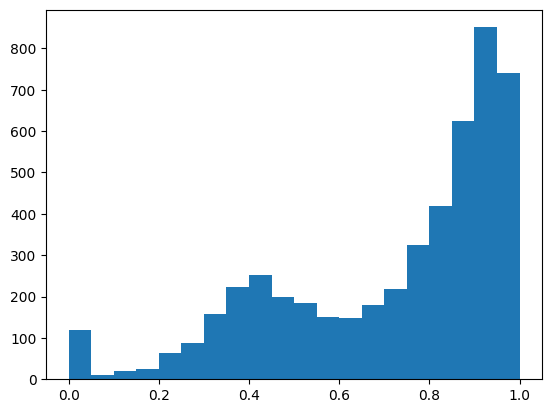

In [7]:
from matplotlib import pyplot as plt
plt.hist(pooled_scores, bins=20)

In [6]:
from cleanlab.object_detection.rank import get_label_quality_scores, compute_badloc_box_scores, compute_overlooked_box_scores, compute_swap_box_scores
from cleanlab.object_detection.filter import find_label_issues

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
cleanlab_labels = []
for label in y_i:
    cleanlab_labels.append({
        'bboxes': label['boxes'],    # Convert 'boxes' to 'bboxes'
        'labels': label['labels'],   # This assumes labels are 1 to 90, handle missing indices if necessary
    })

# Initialize the predictions list with an empty list for each image
cleanlab_predictions = [[[] for _ in range(90)] for _ in range(len(p_ij))]

# Assuming `preds` is your existing predictions data
for idx, pred in enumerate(p_ij):
    # Split predictions by class
    for class_idx in range(90):  # Assuming class indices range from 1 to 90
        # Filter predictions for the current class
        class_mask = pred['labels'] == (class_idx + 1)
        class_boxes = pred['boxes'][class_mask]
        class_scores = pred['scores'][class_mask]
        
        if len(class_boxes) == 0:
            continue
        # Stack boxes and scores horizontally
        class_predictions = np.hstack((class_boxes, class_scores[:, np.newaxis]))
        
        # Append to the corresponding list for this image
        cleanlab_predictions[idx][class_idx].append(class_predictions)

In [8]:
for j, pred in enumerate(cleanlab_predictions):
    for i, p in enumerate(pred):
        pred[i] = np.array(p[0]) if len(p) > 0 else np.zeros((0, 5))

In [14]:
for i, p in enumerate(cleanlab_predictions[0]):
    print("class", i, p.shape)

class 0 (2, 5)
class 1 (0, 5)
class 2 (0, 5)
class 3 (0, 5)
class 4 (0, 5)
class 5 (0, 5)
class 6 (0, 5)
class 7 (0, 5)
class 8 (0, 5)
class 9 (0, 5)
class 10 (0, 5)
class 11 (0, 5)
class 12 (0, 5)
class 13 (0, 5)
class 14 (0, 5)
class 15 (0, 5)
class 16 (0, 5)
class 17 (0, 5)
class 18 (0, 5)
class 19 (0, 5)
class 20 (0, 5)
class 21 (0, 5)
class 22 (0, 5)
class 23 (0, 5)
class 24 (0, 5)
class 25 (0, 5)
class 26 (0, 5)
class 27 (0, 5)
class 28 (0, 5)
class 29 (0, 5)
class 30 (0, 5)
class 31 (0, 5)
class 32 (0, 5)
class 33 (0, 5)
class 34 (0, 5)
class 35 (0, 5)
class 36 (0, 5)
class 37 (0, 5)
class 38 (0, 5)
class 39 (0, 5)
class 40 (0, 5)
class 41 (0, 5)
class 42 (0, 5)
class 43 (1, 5)
class 44 (0, 5)
class 45 (0, 5)
class 46 (0, 5)
class 47 (0, 5)
class 48 (0, 5)
class 49 (0, 5)
class 50 (0, 5)
class 51 (0, 5)
class 52 (0, 5)
class 53 (0, 5)
class 54 (0, 5)
class 55 (0, 5)
class 56 (0, 5)
class 57 (0, 5)
class 58 (0, 5)
class 59 (0, 5)
class 60 (0, 5)
class 61 (3, 5)
class 62 (0, 5)
cl

In [16]:
label_scores = get_label_quality_scores(cleanlab_labels, cleanlab_predictions)

Pruning 0 predictions out of 16606 using threshold==0.0. These predictions are no longer considered as potential candidates for identifying label issues as their similarity with the given labels is no longer considered.


In [17]:
len(label_scores)

5000

(array([ 144.,   48.,  100.,  109.,   94.,   60.,   77.,  186.,  613.,
        1177.,  925.,  467.,  265.,  123.,   83.,   32.,   34.,   16.,
          16.,  431.]),
 array([1.59540307e-34, 5.00000000e-02, 1.00000000e-01, 1.50000000e-01,
        2.00000000e-01, 2.50000000e-01, 3.00000000e-01, 3.50000000e-01,
        4.00000000e-01, 4.50000000e-01, 5.00000000e-01, 5.50000000e-01,
        6.00000000e-01, 6.50000000e-01, 7.00000000e-01, 7.50000000e-01,
        8.00000000e-01, 8.50000000e-01, 9.00000000e-01, 9.50000000e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

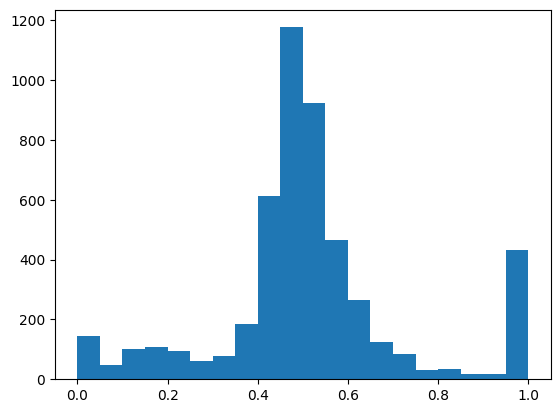

In [18]:
import matplotlib.pyplot as plt
plt.hist(label_scores, bins=20)

In [12]:
temp_labels, temp_predictions = [], []
missing_gt_indices = []
for i, (lab, pred) in enumerate(zip(cleanlab_labels, cleanlab_predictions)):
    b = lab['bboxes']
    if len(b) == 0:
        missing_gt_indices.append(i)
        continue
    temp_labels.append(lab)
    temp_predictions.append(pred)

In [20]:
cl_badloc_scores = compute_badloc_box_scores(labels=cleanlab_labels, predictions=cleanlab_predictions)
cl_overlooked_scores = compute_overlooked_box_scores(labels=cleanlab_labels, predictions=cleanlab_predictions)
cl_swapped_scores = compute_swap_box_scores(labels=cleanlab_labels, predictions=cleanlab_predictions)

In [22]:
from src.conflearn.utils import softmin1d_pooling

In [25]:
cl_badloc_scores = [softmin1d_pooling(s, temperature=0.1) for s in cl_badloc_scores]
cl_overlooked_scores = [softmin1d_pooling(s, temperature=0.1) for s in cl_overlooked_scores]
cl_swapped_scores = [softmin1d_pooling(s, temperature=0.1) for s in cl_swapped_scores]

In [27]:
len(cl_badloc_scores)

5000

In [35]:
import torch
a = torch.rand(5)
print((-a).softmax(dim=0))
print((1-a).softmax(dim=0))

tensor([0.1518, 0.2004, 0.2670, 0.2525, 0.1284])
tensor([0.1518, 0.2004, 0.2670, 0.2525, 0.1284])


In [27]:
plt.hist(cl_badloc_scores)

(array([[ 0.,  0.,  0., ...,  0.,  0., 20.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 1.,  0.,  0., ...,  0.,  0., 17.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  2.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 2.,  0.,  0., ...,  0.,  0., 12.]]),
 array([8.84351544e-06, 1.00007959e-01, 2.00007075e-01, 3.00006190e-01,
        4.00005306e-01, 5.00004422e-01, 6.00003537e-01, 7.00002653e-01,
        8.00001769e-01, 9.00000884e-01, 1.00000000e+00]),
 <a list of 4952 BarContainer objects>)

Error in callback <function flush_figures at 0x7f392ef1c430> (for post_execute):


KeyboardInterrupt: 

In [ ]:
plt.hist(cl_overlooked_scores)

In [ ]:
plt.hist(cl_swapped_scores)

In [13]:
cl_scores = get_label_quality_scores(labels=temp_labels, predictions=temp_predictions)

Pruning 0 predictions out of 16567 using threshold==0.0. These predictions are no longer considered as potential candidates for identifying label issues as their similarity with the given labels is no longer considered.


(array([ 190.,  209.,  154.,  263., 1790., 1392.,  388.,  115.,   50.,
         401.]),
 array([1.59540307e-34, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

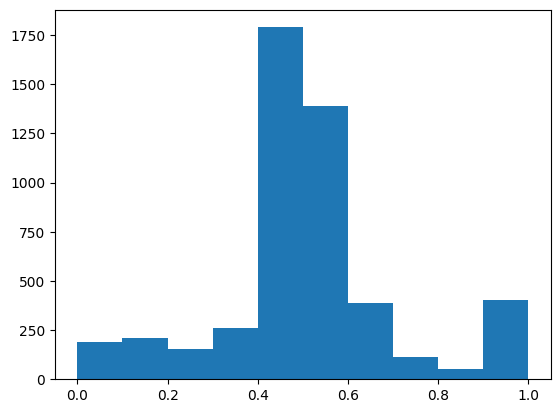

In [14]:
plt.hist(cl_scores)

In [15]:
cl_idxs = np.argsort(cl_scores)

In [16]:
from torchvision.datasets import CocoDetection
coco = CocoDetection(
    root="/datasets/open/coco/val2017", 
    annFile="/datasets/open/coco/annotations_trainval2017/annotations/instances_val2017.json", 
    transform=None,
    target_transform=None
)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [43]:
cl_rank = -2
cl_idx = cl_idxs[cl_rank]
cl_label = temp_labels[cl_idx]
cl_pred = temp_predictions[cl_idx]
cl_image, cl_target = coco[cl_idx]

/tmp/ipykernel_1514944/1632839329.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_labels)


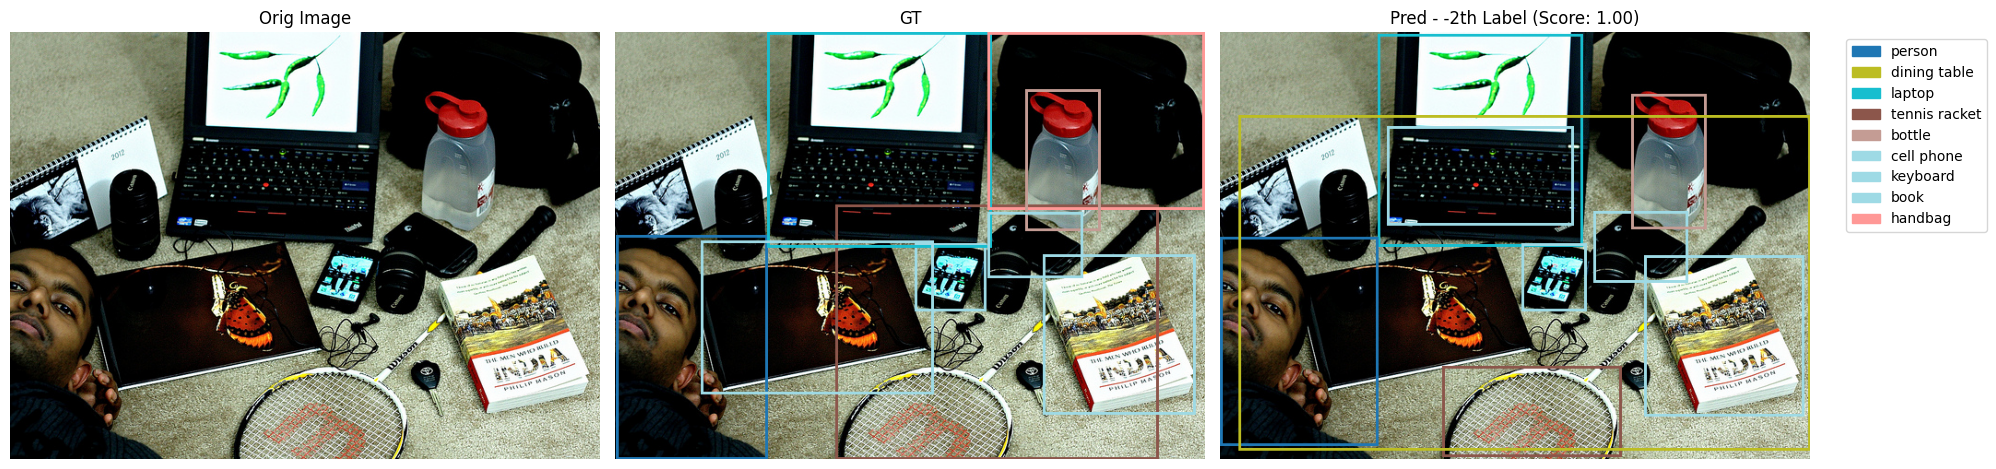

In [44]:
catIds = coco.coco.getCatIds()
cats = coco.coco.loadCats(catIds)
id_to_cat = {cat['id']: cat['name'] for cat in cats}
id_to_cat[0] = 'background'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

num_labels = len(catIds)  
colors = plt.cm.get_cmap('tab20', num_labels) 

existing_indices = set([t["category_id"] for t in cl_target] + p_ij[cl_idx]['labels'].tolist())

# Create a list of patches for the legend
legend_patches = [Patch(color=colors(label)[:3], label=id_to_cat[label]) for label in existing_indices]
pred_boxes = p_ij[cl_idx]['boxes'].tolist()
pred_labels = p_ij[cl_idx]['labels'].tolist()
pred_colors = [colors(label)[:3] for label in pred_labels]

target_boxes = [t["bbox"] for t in cl_target]
target_labels = [t["category_id"] for t in cl_target]
target_colors = [colors(label)[:3] for label in target_labels] 

overlay_image = cl_image.copy()
pred_overlay_image = cl_image.copy()
# Plot
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(cl_image)
plt.title('Orig Image')
plt.axis('off')

from PIL import ImageDraw
plt.subplot(1, 3, 2)
overlay_draw = ImageDraw.Draw(overlay_image)
for box, color in zip(target_boxes, target_colors):
    b = box[:]
    b[2] += b[0]
    b[3] += b[1]
    overlay_draw.rectangle(b, outline=tuple((np.array(color) * 255).astype(int)), width=3)
plt.imshow(overlay_image)
plt.title('GT')
plt.axis('off')

plt.subplot(1, 3, 3)
pred_overlay_draw = ImageDraw.Draw(pred_overlay_image)
for box, color in zip(pred_boxes, pred_colors):
    if box[0] > box[2] or box[1] > box[3]:
        continue

    pred_overlay_draw.rectangle(box, outline=tuple((np.array(color) * 255).astype(int)), width=3)
plt.imshow(pred_overlay_image)
plt.title(f'Pred - {cl_rank}th Label (Score: {cl_scores[cl_idx]:.2f})')
plt.axis('off')

plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("obj.png")

In [21]:
existing_indices = set(range(len(badloc_scores))) - set(missing_gt_indices)

In [22]:
existing_badloc_scores = [badloc_scores[i] for i in existing_indices]
existing_overlooked_scores = [overlooked_scores[i] for i in existing_indices]
existing_swapped_scores = [swapped_scores[i] for i in existing_indices]

In [23]:
pooled_scores = [(s1 * s2 * s3) ** (1/3) for s1, s2, s3 in zip(existing_badloc_scores, existing_overlooked_scores, existing_swapped_scores)]

In [24]:
pooled_idxs = np.argsort(pooled_scores)

In [29]:
rank = 1
idx = pooled_idxs[rank]
image, target = coco[idx]
pred = p_ij[idx]
bs, os, ss = existing_badloc_scores[idx], existing_overlooked_scores[idx], existing_swapped_scores[idx]

/tmp/ipykernel_1514944/1962182399.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_labels)


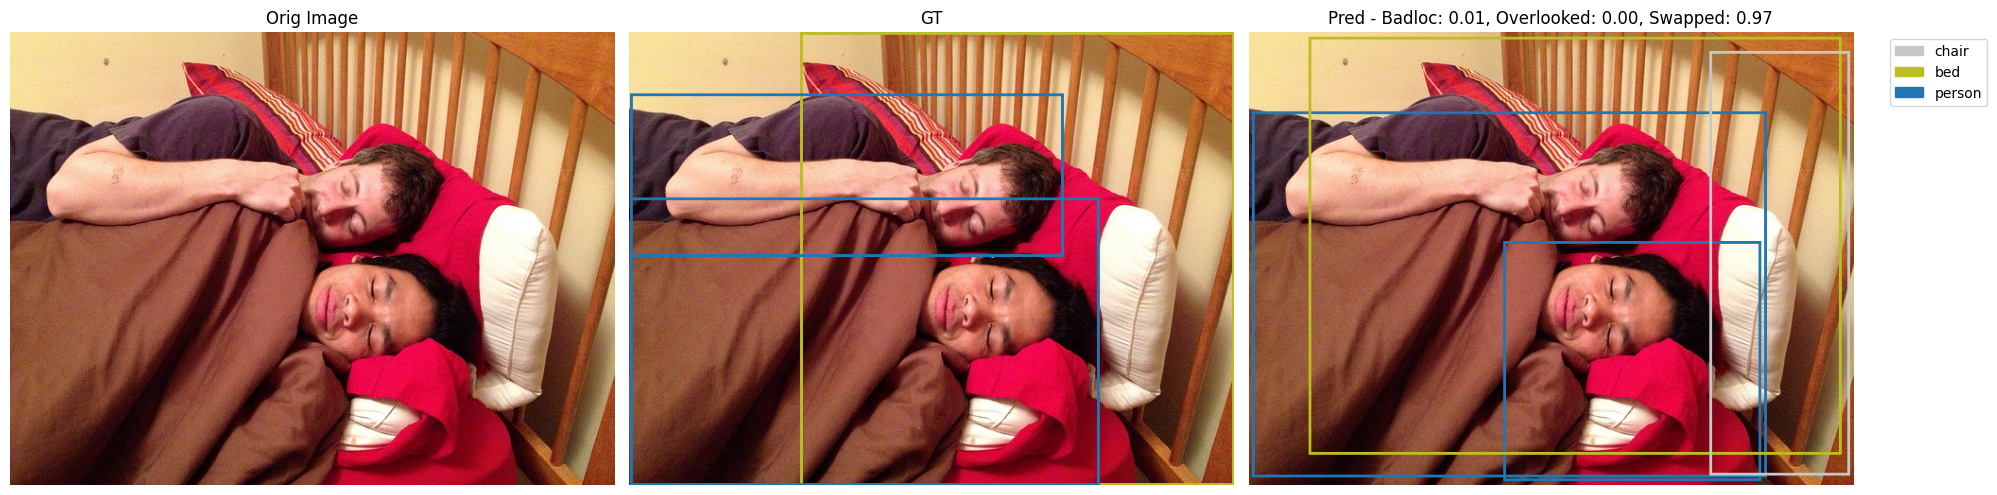

In [30]:
catIds = coco.coco.getCatIds()
cats = coco.coco.loadCats(catIds)
id_to_cat = {cat['id']: cat['name'] for cat in cats}
id_to_cat[0] = 'background'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

num_labels = len(catIds)  
colors = plt.cm.get_cmap('tab20', num_labels) 

existing_indices = set([t["category_id"] for t in target] + pred['labels'].tolist())

# Create a list of patches for the legend
legend_patches = [Patch(color=colors(label)[:3], label=id_to_cat[label]) for label in existing_indices]
pred_boxes = pred['boxes'].tolist()
pred_labels = pred['labels'].tolist()
pred_colors = [colors(label)[:3] for label in pred_labels]

target_boxes = [t["bbox"] for t in target]
target_labels = [t["category_id"] for t in target]
target_colors = [colors(label)[:3] for label in target_labels] 

overlay_image = image.copy()
pred_overlay_image = image.copy()
# Plot
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Orig Image')
plt.axis('off')

from PIL import ImageDraw
plt.subplot(1, 3, 2)
overlay_draw = ImageDraw.Draw(overlay_image)
for box, color in zip(target_boxes, target_colors):
    b = box[:]
    b[2] += b[0]
    b[3] += b[1]
    overlay_draw.rectangle(b, outline=tuple((np.array(color) * 255).astype(int)), width=3)
plt.imshow(overlay_image)
plt.title('GT')
plt.axis('off')

plt.subplot(1, 3, 3)
pred_overlay_draw = ImageDraw.Draw(pred_overlay_image)
for box, color in zip(pred_boxes, pred_colors):
    if box[0] > box[2] or box[1] > box[3]:
        continue

    pred_overlay_draw.rectangle(box, outline=tuple((np.array(color) * 255).astype(int)), width=3)
plt.imshow(pred_overlay_image)
plt.title(f'Pred - Badloc: {bs:.2f}, Overlooked: {os:.2f}, Swapped: {ss:.2f}')
plt.axis('off')

plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("obj.png")

In [62]:
from PIL import ImageDraw
draw = ImageDraw.Draw(image)
for t in target:
    boxes = t['bbox']
    category_id = t["category_id"]
    boxes[2] += boxes[0]
    boxes[3] += boxes[1]
    draw.rectangle(boxes, outline="red")

# Segmentation

In [7]:
# Adapted from torchvision/references/segmentation/coco_utils.py
CAT_LIST = [0, 5, 2, 16, 9, 44, 6, 3, 17, 62, 21, 67, 18, 19, 4, 1, 64, 20, 63, 7, 72]

import os
import copy 

from PIL import Image
from pycocotools import mask as coco_mask
import torch
from torchvision import transforms as T
from torchvision.datasets import CocoDetection

class FilterAndRemapCocoCategories:
    def __init__(self, categories, remap=True):
        self.categories = categories
        self.remap = remap

    def __call__(self, image, anno):
        anno = [obj for obj in anno if obj["category_id"] in self.categories]
        if not self.remap:
            return image, anno
        anno = copy.deepcopy(anno)
        for obj in anno:
            obj["category_id"] = self.categories.index(obj["category_id"])
        return image, anno

def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks

class ConvertCocoPolysToMask:
    def __call__(self, image, anno):
        w, h = image.size
        segmentations = [obj["segmentation"] for obj in anno]
        cats = [obj["category_id"] for obj in anno]
        if segmentations:
            masks = convert_coco_poly_to_mask(segmentations, h, w)
            cats = torch.as_tensor(cats, dtype=masks.dtype)
            # merge all instance masks into a single segmentation map
            # with its corresponding categories
            target, _ = (masks * cats[:, None, None]).max(dim=0)
            # discard overlapping instances
            # MODIFIED: in original code, overlapping instances are set to 255, then ignored in training by ignore_index=255
            # but, in this code, overlapping instances are set to 0, i.e. background
            target[masks.sum(0) > 1] = 0
        else:
            target = torch.zeros((h, w), dtype=torch.uint8)
        target = Image.fromarray(target.numpy())
        return image, target

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target
    
def get_valid_coco(root, transforms):
    img_folder = os.path.join(root, "val2017")
    ann_file = os.path.join(root, "annotations_trainval2017/annotations/instances_val2017.json")

    transform = [FilterAndRemapCocoCategories(CAT_LIST, remap=True), ConvertCocoPolysToMask()]
    if transforms:
        transform.append(transforms)

    dataset = CocoDetection(img_folder, ann_file, transforms=Compose(transform))
    return dataset

In [8]:
from torchvision import models
from torchvision.transforms import functional as F
from torchvision.transforms import InterpolationMode

def get_pretrained_model_and_transform(model, weight_name):
    weight = models.get_weight(weight_name)
    model = models.get_model(model, weights=weight)
    transform = weight.transforms()

    def preprocessing(img, target):
        img = transform(img)
        size = F.get_dimensions(img)[1:]
        target = F.resize(target, size, interpolation=InterpolationMode.NEAREST)
        return img, F.pil_to_tensor(target)
    
    return model, preprocessing 

In [9]:
model, transform = get_pretrained_model_and_transform("fcn_resnet50", "FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1")

In [10]:
coco = get_valid_coco("/datasets/open/coco", transform)

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [17]:
for a in coco:
    print(a[1].shape)

torch.Size([1, 520, 781])
torch.Size([1, 567, 520])
torch.Size([1, 520, 689])
torch.Size([1, 693, 520])
torch.Size([1, 777, 520])
torch.Size([1, 520, 783])
torch.Size([1, 784, 520])
torch.Size([1, 535, 520])
torch.Size([1, 520, 779])
torch.Size([1, 520, 693])
torch.Size([1, 520, 779])
torch.Size([1, 779, 520])
torch.Size([1, 693, 520])
torch.Size([1, 520, 650])
torch.Size([1, 520, 1056])
torch.Size([1, 520, 693])
torch.Size([1, 520, 693])
torch.Size([1, 520, 520])
torch.Size([1, 520, 693])
torch.Size([1, 779, 520])
torch.Size([1, 520, 783])
torch.Size([1, 520, 794])
torch.Size([1, 520, 693])
torch.Size([1, 520, 779])
torch.Size([1, 520, 693])
torch.Size([1, 520, 779])
torch.Size([1, 520, 779])
torch.Size([1, 520, 860])
torch.Size([1, 728, 520])
torch.Size([1, 520, 779])
torch.Size([1, 693, 520])
torch.Size([1, 520, 693])
torch.Size([1, 520, 909])
torch.Size([1, 520, 599])
torch.Size([1, 520, 693])
torch.Size([1, 751, 520])
torch.Size([1, 520, 916])
torch.Size([1, 520, 520])
torch.Size(

KeyboardInterrupt: 

In [6]:
model = model.eval().cuda()

In [ ]:
from tqdm import tqdm 
y = []

c_hat = []
p_max = []
p_selfconf = []

for i, (image, target) in enumerate(tqdm(coco, total=len(coco))):
    image_gpu = image.to('cuda')

    with torch.no_grad():
        output = model(image_gpu[None])

    # K x H x W 
    pred_mask = output['out'].cpu().softmax(dim=1).squeeze(0)

    # H x W
    pred_classes = pred_mask.argmax(dim=0)

    # (K x H x W).gather(0, 1 x H x W) -> 1 x H x W -> H x W
    max_prob = pred_mask.gather(0, pred_classes.unsqueeze(0)).squeeze(0)

    target = target.long().squeeze(0)

    selfconf_prob = pred_mask.gather(0, target.unsqueeze(0)).squeeze(0)

    y.append(target)
    c_hat.append(pred_classes)
    p_max.append(max_prob)
    p_selfconf.append(selfconf_prob)

In [ ]:
# torch.save(y, "seg_y.pt")
# torch.save(c_hat, "seg_pred_c.pt")
# torch.save(p_max, "seg_p_max.pt")
# torch.save(p_selfconf, "seg_p_selfconf.pt")

In [48]:
import torch
y, c_hat, p_max, p_selfconf = torch.load("seg_y.pt"), torch.load("seg_pred_c.pt"), torch.load("seg_p_max.pt"), torch.load("seg_p_selfconf.pt")

In [49]:
from tqdm import tqdm

from src.eval_utils import softmin

class Segmentation:
    def __init__(self, labels, pred_masks, pred_max_probs, pred_selfconf_probs, num_classes):
        self.labels = labels
        self.pred_masks = pred_masks
        self.pred_max_probs = pred_max_probs
        self.pred_selfconf_probs = pred_selfconf_probs
        self.num_classes = num_classes
    
    def get_result(self, pooling=False, softmin_temperature=0.1):
        scores = []
        for pred_selfconf, gt_mask in tqdm(zip(self.pred_selfconf_probs, self.labels), total=len(self.labels), desc="Calculating scores"):
            score = pred_selfconf
            if pooling:
                weights = softmin(pred_selfconf, temperature=softmin_temperature)
                score = weights * pred_selfconf
                score = score.sum()
            
            scores.append(score)
        return scores

In [61]:
# to_numpy = lambda x: x.numpy()
# y = list(map(to_numpy, y))
# c_hat = list(map(to_numpy, c_hat))
# p_max = list(map(to_numpy, p_max))
# p_selfconf = list(map(to_numpy, p_selfconf))

seg = Segmentation(y, c_hat, p_max, p_selfconf, num_classes=len(CAT_LIST))

In [82]:
scores = seg.get_result(pooling=True)

Calculating scores: 100%|██████████| 5000/5000 [00:03<00:00, 1489.30it/s]


In [66]:
# for visualization, need to invert normalization
inv_normalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

In [85]:
sorted_ind = np.argsort(scores)
ind = sorted_ind[1]

score = scores[ind]
image = inv_normalize(coco[ind][0])
target = coco[ind][1]
pred_mask = c_hat[ind]


/tmp/ipykernel_98508/23910605.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_labels)


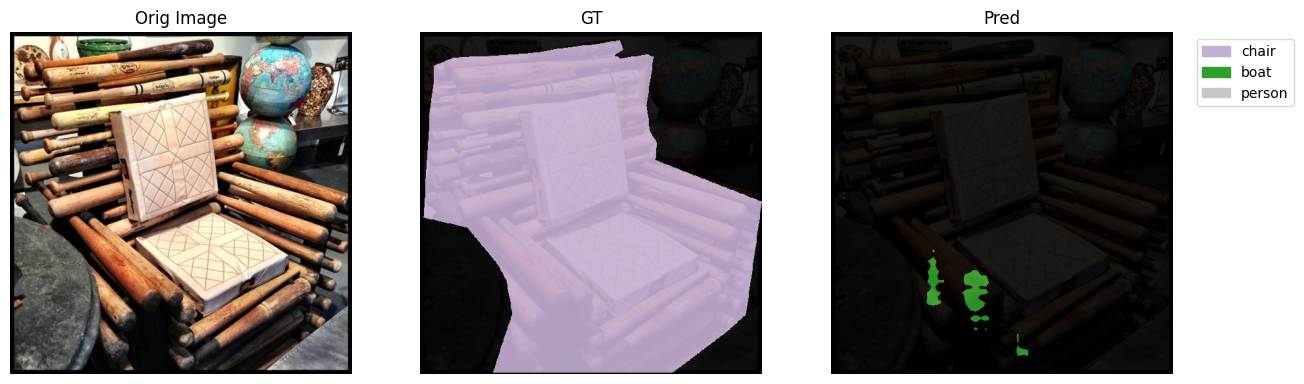

In [86]:
catIds = coco.coco.getCatIds()
cats = coco.coco.loadCats(catIds)
id_to_cat = {cat['id']: cat['name'] for cat in cats}
id_to_cat[0] = 'background'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

numpy_image = image.permute(1, 2, 0).cpu().numpy()
numpy_mask = target.cpu().squeeze().numpy()

num_labels = len(CAT_LIST)  
colors = plt.cm.get_cmap('tab20', num_labels) 

colored_mask = np.zeros((*numpy_mask.shape, 3), dtype=np.float32)

existing_indices = set()

for label in range(1, num_labels + 1):  
    mask = numpy_mask == label
    if np.any(mask):
        existing_indices.add(label)

    colored_mask[mask] = colors(label)[:3]  # Ignore alpha channel

alpha = 0.9
overlay_image = (numpy_image * (1 - alpha) + colored_mask * alpha).clip(0, 1)

# For prediction
colored_pred_mask = np.zeros((*numpy_mask.shape, 3), dtype=np.float32)

for label in range(1, num_labels + 1):  # Start from 1 to skip the background
    mask = pred_mask == label
    if np.any(mask):
        existing_indices.add(label)

    colored_pred_mask[mask] = colors(label)[:3]  # Ignore alpha channel

alpha = 0.9
pred_overlay_image = (numpy_image * (1 - alpha) + colored_pred_mask * alpha).clip(0, 1)

# Create a list of patches for the legend
legend_patches = [Patch(color=colors(label)[:3], label=id_to_cat[CAT_LIST[label]]) for label in existing_indices]

# Plot
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(numpy_image)
plt.title('Orig Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(overlay_image)
plt.title('GT')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_overlay_image)
plt.title('Pred')
plt.axis('off')

plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [14]:
from cleanlab.segmentation.filter import find_label_issues
from cleanlab.segmentation.rank import get_label_quality_scores

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
for i, (image, target) in enumerate(tqdm(coco, total=len(coco))):
    image_gpu = image.to('cuda')

    with torch.no_grad():
        output = model(image_gpu[None])

    pred_mask = output['out'].cpu().softmax(dim=1).squeeze(0)
    break

  0%|          | 0/5000 [00:00<?, ?it/s]


In [16]:
target = target.numpy()
pred_mask = pred_mask.unsqueeze(0).numpy()

In [17]:
image_score, pixel_scores = get_label_quality_scores(target, pred_mask)

images processed using softmin: 100%|██████████| 1/1 [00:00<00:00, 89.88it/s]


In [18]:
image_score

array([0.07560862])

In [19]:
pixel_scores

array([[[0.99911505, 0.99911505, 0.99911505, ..., 0.9929069 ,
         0.9929069 , 0.9929069 ],
        [0.99911505, 0.99911505, 0.99911505, ..., 0.9929069 ,
         0.9929069 , 0.9929069 ],
        [0.99911505, 0.99911505, 0.99911505, ..., 0.9929069 ,
         0.9929069 , 0.9929069 ],
        ...,
        [0.74278396, 0.74278396, 0.74278396, ..., 0.50608927,
         0.50608927, 0.50608927],
        [0.74278396, 0.74278396, 0.74278396, ..., 0.50608927,
         0.50608927, 0.50608927],
        [0.74278396, 0.74278396, 0.74278396, ..., 0.50608927,
         0.50608927, 0.50608927]]], dtype=float32)

In [5]:
from torchvision.transforms import functional as F
import torch 
random_image = torch.randint(0, 255, (3, 256, 256))

F.convert_image_dtype(random_image)

tensor([[[2.1034e-17, 4.0115e-18, 2.6997e-17,  ..., 4.5536e-18,
          2.6129e-17, 7.5894e-18],
         [2.6021e-18, 2.2877e-17, 1.0300e-17,  ..., 2.7105e-17,
          2.0600e-18, 1.3878e-17],
         [2.7105e-17, 8.6736e-19, 1.5613e-17,  ..., 4.5536e-18,
          5.4210e-18, 1.4203e-17],
         ...,
         [1.7889e-17, 9.5410e-18, 2.2551e-17,  ..., 1.6697e-17,
          9.7578e-18, 3.2526e-18],
         [4.0115e-18, 2.7539e-17, 1.0192e-17,  ..., 2.0275e-17,
          1.8865e-17, 2.7430e-17],
         [2.7430e-17, 2.4069e-17, 1.2251e-17,  ..., 1.4420e-17,
          1.8540e-17, 1.1601e-17]],

        [[2.6238e-17, 1.4528e-17, 2.0600e-18,  ..., 1.4637e-17,
          1.7672e-17, 6.2884e-18],
         [0.0000e+00, 2.2443e-17, 1.4745e-17,  ..., 1.3769e-17,
          4.9873e-18, 1.9190e-17],
         [1.8648e-17, 3.2526e-18, 2.0817e-17,  ..., 2.2009e-17,
          8.6736e-18, 1.3878e-17],
         ...,
         [1.9732e-17, 2.0383e-17, 8.4568e-18,  ..., 2.5912e-17,
          8.348

In [4]:
random_image

tensor([[[226,  86, 233,  ...,  77, 154, 104],
         [243,  67,  53,  ..., 174, 246,  77],
         [174, 254,   7,  ..., 210, 145, 222],
         ...,
         [170, 131, 244,  ..., 221,  21, 129],
         [ 60,  24, 167,  ..., 160, 229,  19],
         [182, 154,  80,  ...,  29, 169, 119]],

        [[170, 251, 228,  ..., 170,  12, 119],
         [ 81,  64, 127,  ..., 109, 225, 158],
         [223, 162, 210,  ..., 171, 209,  56],
         ...,
         [105, 132, 164,  ..., 147, 177, 150],
         [130,  83, 208,  ...,  89, 215, 113],
         [174, 111, 168,  ..., 143, 154, 248]],

        [[114,  38, 198,  ..., 218, 244,  26],
         [130, 134,   6,  ..., 241, 235,  49],
         [  0, 104, 236,  ..., 235, 225, 146],
         ...,
         [136, 218, 141,  ..., 108, 165, 209],
         [216, 237, 134,  ..., 208, 218, 162],
         [151,  51, 168,  ..., 198, 136, 101]]])